In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import CHILDES_DFS, DATA_DIR
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm

<ipython-input-3-5dad22dbb65b>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [46]:
transcript_df = pd.read_pickle(CHILDES_DFS/'childes_df_eng_corpora.pickle')
#transcript_df['dataset'] = [i[0].split('/')[11] for i in transcript_df.transcript_xml.values]
len(transcript_df)

7132

In [5]:
# mask for only a subset of corpuses
possible_corpuses = [
    # carterette is also transcribed in IPA
    "Carterette",  # 1st, 3rd, 5th grade, adults, speech naturalistic speech in IPA https://childes.talkbank.org/access/Eng-NA/Carterette.html
    "Gillam",  # normal subset, spontaneous storytelling 5-11y11m https://childes.talkbank.org/access/Clinical-MOR/Gillam.html
    "Braunwald",  # single subject from 1-6yo talking to family https://childes.talkbank.org/access/Eng-NA/Braunwald.html
    "Brown",  # 1y6m-5y1m, 3 subjects naturalistic talking to parents https://childes.talkbank.org/access/Eng-NA/Brown.html
    "EllisWeismer",  # 2y6m - 5y6 naturalistic play-oriented talk with instructor # https://childes.talkbank.org/access/Clinical-MOR/EllisWeismer.html
    "Gleason",  # 2;1 - 5;2 family interactions https://childes.talkbank.org/access/Eng-NA/Gleason.html
    "NH",# Nicholas-NH,  # 1;0-4;0, videotaped play with parent https://childes.talkbank.org/access/Clinical-MOR/Nicholas/NH.html
    "Post",  # 1;7-2;8 60m session with family and toys https://childes.talkbank.org/access/Eng-NA/Post.html
    "Normal",  #  Rondal-Normal 3-12yo free play with mother and child https://childes.talkbank.org/access/Clinical-MOR/Normal /Normal.html
]
corpus_mask = [corpus in possible_corpuses for corpus in transcript_df.corpus.values]
transcript_df = transcript_df[corpus_mask]

In [6]:
#transcript_df.to_pickle(CHILDES_DFS/'childes_df_eng_corpora.pickle')

In [7]:
# mask for a subset of roles
#possible_roles = ['Target_Child', 'Child']
#role_mask = [role in possible_roles for role in transcript_df.role.values]
#transcript_df = transcript_df[role_mask]
len(transcript_df)

7132

In [8]:
transcript_df[:3]

,PID,lang,corpus,date,participant_key,role,age,language,sex,POS,words,morphemes,transcript_xml,n_words,n_morphemes,n_POS
5733,11312/c-00005910-1,eng,NH,1992-08-08,CHI,Target_Child,P4Y00M10D,eng,male,"[[], [], [pro:sub, mod~neg, v], [], [], [], [p...","[[], [], [I, don't, know], [], [], [xxx], [I, ...","[[], [], [I, do~not, know], [], [], [xxx], [I,...",[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,238,238,238
5734,11312/c-00005910-1,eng,NH,1992-08-08,MOT,Mother,NaN,eng,female,"[[v, pro:dem], [pro:int], [v, det:art, n], [mo...","[[use, this], [what], [use, the, stick], [can,...","[[use, this], [what], [use, the, stick], [can,...",[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,317,317,317
5735,11312/c-00005890-1,eng,NH,1992-10-29,CHI,Target_Child,P3Y06M04D,eng,female,"[[co, pro:sub, v], [pro:sub, v, pro:per~aux, p...","[[yeah, we, do], [I, think, it's, lost], [yeah...","[[yeah, we, do], [I, think, it~be, lose-PASTP]...",[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,302,302,302


In [23]:
PID_DF = pd.DataFrame(columns = ['PID', 'child_words', 'total_words', 'word_prop'])
for PID in tqdm(transcript_df.PID.unique(), total=len(transcript_df.PID.unique())):
    transcript_df_subset = transcript_df[transcript_df.PID == PID]
    child_words = transcript_df_subset[transcript_df_subset.role.isin(['Target_Child', 'Child'])].n_words.sum()
    total_words = transcript_df_subset.n_words.sum()
    PID_DF.loc[len(PID_DF)] = [
        PID, child_words, total_words, child_words/total_words
    ]
    
PID_DF[:3]

  0%|          | 0/2774 [00:00<?, ?it/s]

<ipython-input-23-e831f951d82b>:7: RuntimeWarning: invalid value encountered in long_scalars
  PID, child_words, total_words, child_words/total_words


,PID,child_words,total_words,word_prop
0,11312/c-00005910-1,238,555,0.428829
1,11312/c-00005890-1,302,657,0.459665
2,11312/c-00005874-1,275,612,0.449346


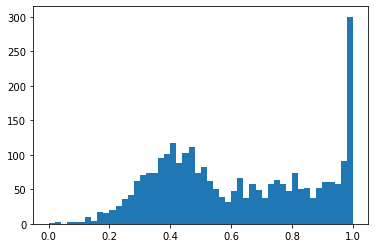

In [27]:
plt.hist(PID_DF.word_prop.values, bins=50);

In [12]:
transcript_df_subset.n_words

5733    238
5734    317
Name: n_words, dtype: int64

In [28]:
print("there are {} words in this dataset".format(np.sum(transcript_df.n_words.values)))

there are 765306 words in this dataset


### Get child ages

In [49]:
import re
def convert_age(age_year):
    "Caclculate age in months from a string in CHILDES format"
    if age_year[-1] == 'Y':
        age_year += '0'
    m = re.match("P(\d+)Y(\d+)M?(\d?\d?)D?", age_year)
    age_month = int(m.group(1)) * 12 + int(m.group(2))
    try:
        if int(m.group(3)) > 15:
            age_month += 1
    # some corpora don't have age information?
    except ValueError as e:
        pass
    return age_month

In [52]:
# mask for a subset of roles
possible_roles = ['Target_Child', 'Child']
role_mask = [role in possible_roles for role in transcript_df.role.values]
transcript_df_child = transcript_df[role_mask]
len(transcript_df_child)

2785

In [64]:
transcript_df_child["age_months"] = [
    convert_age(i) if type(i) == str else np.nan for i in tqdm(transcript_df_child.age.values)
]
transcript_df_child["age_years"] = transcript_df["age_months"] / 12

  0%|          | 0/2785 [00:00<?, ?it/s]

<ipython-input-64-880739ed4b64>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcript_df_child["age_months"] = [
<ipython-input-64-880739ed4b64>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcript_df_child["age_years"] = transcript_df["age_months"] / 12


In [66]:
transcript_df_child[:3]

,PID,lang,corpus,date,participant_key,role,age,language,sex,POS,words,morphemes,transcript_xml,n_words,n_morphemes,n_POS,age_months,age_years
5733,11312/c-00005910-1,eng,NH,1992-08-08,CHI,Target_Child,P4Y00M10D,eng,male,"[[], [], [pro:sub, mod~neg, v], [], [], [], [p...","[[], [], [I, don't, know], [], [], [xxx], [I, ...","[[], [], [I, do~not, know], [], [], [xxx], [I,...",[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,238,238,238,48.0,4.000000
5735,11312/c-00005890-1,eng,NH,1992-10-29,CHI,Target_Child,P3Y06M04D,eng,female,"[[co, pro:sub, v], [pro:sub, v, pro:per~aux, p...","[[yeah, we, do], [I, think, it's, lost], [yeah...","[[yeah, we, do], [I, think, it~be, lose-PASTP]...",[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,302,302,302,42.0,3.500000
5738,11312/c-00005874-1,eng,NH,1994-06-01,CHI,Target_Child,P3Y00M17D,eng,female,"[[], [co], [, v, pro:per], [co, mod, pro:per, ...","[[xxx], [okay], [xxx, thank, you], [hey, can, ...","[[xxx], [okay], [xxx, thank, you], [hey, can, ...",[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,275,275,275,37.0,3.083333


In [67]:
import seaborn as sns
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig
ensure_dir(FIGURE_DIR/ 'distributions')

In [68]:
def quickplot_decay(distances, MI, shuff_MI, title=''):
    fig,axs = plt.subplots(ncols=2, figsize = (10,4))
    ax = axs[0]
    ax.set_title(title)
    ax.scatter(distances, MI-shuff_MI)
    ax.plot(distances, MI-shuff_MI, alpha = 0)
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax = axs[1]
    ax.scatter(distances, MI)
    ax.scatter(distances, shuff_MI)
    plt.show()

In [69]:
age_cohorts = [[1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [70]:
from childes_mi.information_theory import mutual_information as mi

In [71]:
# mask for a subset of roles
#possible_roles = ['Target_Child', 'Child']
#role_mask = [role in possible_roles for role in transcript_df.role.values]
#transcript_df = transcript_df[role_mask]
len(transcript_df_child)

2785

In [ ]:
nex = 1000

MI_DF_long = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_phones",
        "n_unique_phones",
        "age",
        "dataset",
        "xml_loc",
        "n_words",  
        "words_list"
    ]
)
    # for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):# [::-1]
    cohort_subset = transcript_df_child[
        (transcript_df_child.age_years > age_cohort_low) & (transcript_df_child.age_years <= age_cohort_high)
    ]
    print(age_cohort_low, age_cohort_high)
    for idx, longest_row in tqdm(cohort_subset.sort_values(by='n_words', ascending=False)[:nex].iterrows(), total=np.min([nex, len(cohort_subset)])):
        words_list = list(flatten([i for i in flatten(longest_row.words) if i is not None]))
        if len(words_list) < 100:
            continue
    
        n_words = len(words_list)
        n_unique_words = len(np.unique(words_list))
        
        distances = np.arange(1, n_words - 1)
        (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information([list(words_list)],  
                                                                                  distances = distances, n_jobs=1)
                
        #quickplot_decay(distances, MI, shuff_MI, title='')
        
        MI_DF_long.loc[len(MI_DF_long)] = [
            MI,
            MI_var,
            shuff_MI,
            shuff_MI_var,
            distances,
            age_cohort_low,
            age_cohort_high,
            n_words,
            n_unique_words,
            longest_row.age,
            longest_row.corpus,
            longest_row.transcript_xml,
            longest_row.n_words,
            words_list
            
        ]

  0%|          | 0/5 [00:00<?, ?it/s]

1 1.5


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/823 [00:00<?, ?it/s]

  0%|          | 0/823 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/772 [00:00<?, ?it/s]

  0%|          | 0/772 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

1.5 2


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/2493 [00:00<?, ?it/s]

  0%|          | 0/2493 [00:00<?, ?it/s]

  0%|          | 0/1478 [00:00<?, ?it/s]

  0%|          | 0/1478 [00:00<?, ?it/s]

  0%|          | 0/2113 [00:00<?, ?it/s]

  0%|          | 0/2113 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1333 [00:00<?, ?it/s]

  0%|          | 0/1333 [00:00<?, ?it/s]

  0%|          | 0/1219 [00:00<?, ?it/s]

  0%|          | 0/1219 [00:00<?, ?it/s]

  0%|          | 0/1529 [00:00<?, ?it/s]

  0%|          | 0/1529 [00:00<?, ?it/s]

  0%|          | 0/1501 [00:00<?, ?it/s]

  0%|          | 0/1501 [00:00<?, ?it/s]

  0%|          | 0/1526 [00:00<?, ?it/s]

  0%|          | 0/1526 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/826 [00:00<?, ?it/s]

  0%|          | 0/826 [00:00<?, ?it/s]

  0%|          | 0/682 [00:00<?, ?it/s]

  0%|          | 0/682 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/909 [00:00<?, ?it/s]

  0%|          | 0/909 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/343 [00:00<?, ?it/s]

  0%|          | 0/343 [00:00<?, ?it/s]

  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/638 [00:00<?, ?it/s]

  0%|          | 0/638 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/636 [00:00<?, ?it/s]

  0%|          | 0/636 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

  0%|          | 0/308 [00:00<?, ?it/s]

  0%|          | 0/308 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/602 [00:00<?, ?it/s]

  0%|          | 0/602 [00:00<?, ?it/s]

  0%|          | 0/376 [00:00<?, ?it/s]

  0%|          | 0/376 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/494 [00:00<?, ?it/s]

  0%|          | 0/494 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/538 [00:00<?, ?it/s]

  0%|          | 0/538 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/442 [00:00<?, ?it/s]

  0%|          | 0/442 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/285 [00:00<?, ?it/s]

  0%|          | 0/285 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

2 2.5


  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/2901 [00:00<?, ?it/s]

  0%|          | 0/2901 [00:00<?, ?it/s]

  0%|          | 0/2801 [00:00<?, ?it/s]

  0%|          | 0/2801 [00:00<?, ?it/s]

  0%|          | 0/3363 [00:00<?, ?it/s]

  0%|          | 0/3363 [00:00<?, ?it/s]

  0%|          | 0/2367 [00:00<?, ?it/s]

  0%|          | 0/2367 [00:00<?, ?it/s]

  0%|          | 0/2125 [00:00<?, ?it/s]

  0%|          | 0/2125 [00:00<?, ?it/s]

  0%|          | 0/2031 [00:00<?, ?it/s]

  0%|          | 0/2031 [00:00<?, ?it/s]

  0%|          | 0/1979 [00:00<?, ?it/s]

  0%|          | 0/1979 [00:00<?, ?it/s]

  0%|          | 0/2713 [00:00<?, ?it/s]

  0%|          | 0/2713 [00:00<?, ?it/s]

  0%|          | 0/1561 [00:00<?, ?it/s]

  0%|          | 0/1561 [00:00<?, ?it/s]

  0%|          | 0/1502 [00:00<?, ?it/s]

  0%|          | 0/1502 [00:00<?, ?it/s]

  0%|          | 0/2585 [00:00<?, ?it/s]

  0%|          | 0/2585 [00:00<?, ?it/s]

  0%|          | 0/2260 [00:00<?, ?it/s]

  0%|          | 0/2260 [00:00<?, ?it/s]

  0%|          | 0/2297 [00:00<?, ?it/s]

  0%|          | 0/2297 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/619 [00:00<?, ?it/s]

  0%|          | 0/619 [00:00<?, ?it/s]

  0%|          | 0/795 [00:00<?, ?it/s]

  0%|          | 0/795 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/773 [00:00<?, ?it/s]

  0%|          | 0/773 [00:00<?, ?it/s]

  0%|          | 0/1240 [00:00<?, ?it/s]

  0%|          | 0/1240 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/715 [00:00<?, ?it/s]

  0%|          | 0/715 [00:00<?, ?it/s]

  0%|          | 0/1303 [00:00<?, ?it/s]

  0%|          | 0/1303 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1192 [00:00<?, ?it/s]

  0%|          | 0/1192 [00:00<?, ?it/s]

  0%|          | 0/1436 [00:00<?, ?it/s]

  0%|          | 0/1436 [00:00<?, ?it/s]

  0%|          | 0/1164 [00:00<?, ?it/s]

  0%|          | 0/1164 [00:00<?, ?it/s]

  0%|          | 0/1106 [00:00<?, ?it/s]

  0%|          | 0/1106 [00:00<?, ?it/s]

  0%|          | 0/1116 [00:00<?, ?it/s]

  0%|          | 0/1116 [00:00<?, ?it/s]

  0%|          | 0/606 [00:00<?, ?it/s]

  0%|          | 0/606 [00:00<?, ?it/s]

  0%|          | 0/726 [00:00<?, ?it/s]

  0%|          | 0/726 [00:00<?, ?it/s]

  0%|          | 0/953 [00:00<?, ?it/s]

  0%|          | 0/953 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/874 [00:00<?, ?it/s]

  0%|          | 0/874 [00:00<?, ?it/s]

  0%|          | 0/588 [00:00<?, ?it/s]

  0%|          | 0/588 [00:00<?, ?it/s]

  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/832 [00:00<?, ?it/s]

  0%|          | 0/832 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/741 [00:00<?, ?it/s]

  0%|          | 0/741 [00:00<?, ?it/s]

  0%|          | 0/1166 [00:00<?, ?it/s]

  0%|          | 0/1166 [00:00<?, ?it/s]

  0%|          | 0/1190 [00:00<?, ?it/s]

  0%|          | 0/1190 [00:00<?, ?it/s]

  0%|          | 0/674 [00:00<?, ?it/s]

  0%|          | 0/674 [00:00<?, ?it/s]

  0%|          | 0/824 [00:00<?, ?it/s]

  0%|          | 0/824 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/1151 [00:00<?, ?it/s]

  0%|          | 0/1151 [00:00<?, ?it/s]

  0%|          | 0/763 [00:00<?, ?it/s]

  0%|          | 0/763 [00:00<?, ?it/s]

  0%|          | 0/1041 [00:00<?, ?it/s]

  0%|          | 0/1041 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/743 [00:00<?, ?it/s]

  0%|          | 0/743 [00:00<?, ?it/s]

  0%|          | 0/553 [00:00<?, ?it/s]

  0%|          | 0/553 [00:00<?, ?it/s]

  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/532 [00:00<?, ?it/s]

  0%|          | 0/532 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/915 [00:00<?, ?it/s]

  0%|          | 0/915 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/728 [00:00<?, ?it/s]

  0%|          | 0/728 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/769 [00:00<?, ?it/s]

  0%|          | 0/769 [00:00<?, ?it/s]

  0%|          | 0/392 [00:00<?, ?it/s]

  0%|          | 0/392 [00:00<?, ?it/s]

  0%|          | 0/752 [00:00<?, ?it/s]

  0%|          | 0/752 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/729 [00:00<?, ?it/s]

  0%|          | 0/729 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

  0%|          | 0/621 [00:00<?, ?it/s]

  0%|          | 0/621 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/731 [00:00<?, ?it/s]

  0%|          | 0/731 [00:00<?, ?it/s]

  0%|          | 0/870 [00:00<?, ?it/s]

  0%|          | 0/870 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/443 [00:00<?, ?it/s]

  0%|          | 0/443 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/796 [00:00<?, ?it/s]

  0%|          | 0/796 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/308 [00:00<?, ?it/s]

  0%|          | 0/308 [00:00<?, ?it/s]

  0%|          | 0/615 [00:00<?, ?it/s]

  0%|          | 0/615 [00:00<?, ?it/s]

  0%|          | 0/743 [00:00<?, ?it/s]

  0%|          | 0/743 [00:00<?, ?it/s]

  0%|          | 0/530 [00:00<?, ?it/s]

  0%|          | 0/530 [00:00<?, ?it/s]

  0%|          | 0/507 [00:00<?, ?it/s]

  0%|          | 0/507 [00:00<?, ?it/s]

  0%|          | 0/611 [00:00<?, ?it/s]

  0%|          | 0/611 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/412 [00:00<?, ?it/s]

  0%|          | 0/412 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/769 [00:00<?, ?it/s]

  0%|          | 0/769 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/532 [00:00<?, ?it/s]

  0%|          | 0/532 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/808 [00:00<?, ?it/s]

  0%|          | 0/808 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/392 [00:00<?, ?it/s]

  0%|          | 0/392 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/443 [00:00<?, ?it/s]

  0%|          | 0/443 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/431 [00:00<?, ?it/s]

  0%|          | 0/431 [00:00<?, ?it/s]

  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/337 [00:00<?, ?it/s]

  0%|          | 0/337 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/541 [00:00<?, ?it/s]

  0%|          | 0/541 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/578 [00:00<?, ?it/s]

  0%|          | 0/578 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/305 [00:00<?, ?it/s]

  0%|          | 0/305 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/285 [00:00<?, ?it/s]

  0%|          | 0/285 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/268 [00:00<?, ?it/s]

  0%|          | 0/268 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/493 [00:00<?, ?it/s]

  0%|          | 0/493 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/440 [00:00<?, ?it/s]

  0%|          | 0/440 [00:00<?, ?it/s]

  0%|          | 0/382 [00:00<?, ?it/s]

  0%|          | 0/382 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/290 [00:00<?, ?it/s]

  0%|          | 0/290 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/285 [00:00<?, ?it/s]

  0%|          | 0/285 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/427 [00:00<?, ?it/s]

  0%|          | 0/427 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/322 [00:00<?, ?it/s]

  0%|          | 0/322 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

2.5 3


  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/3678 [00:00<?, ?it/s]

  0%|          | 0/3678 [00:00<?, ?it/s]

  0%|          | 0/3677 [00:00<?, ?it/s]

  0%|          | 0/3677 [00:00<?, ?it/s]

  0%|          | 0/2604 [00:00<?, ?it/s]

  0%|          | 0/2604 [00:00<?, ?it/s]

  0%|          | 0/2658 [00:00<?, ?it/s]

  0%|          | 0/2658 [00:00<?, ?it/s]

  0%|          | 0/2506 [00:00<?, ?it/s]

  0%|          | 0/2506 [00:00<?, ?it/s]

  0%|          | 0/2364 [00:00<?, ?it/s]

  0%|          | 0/2364 [00:00<?, ?it/s]

  0%|          | 0/2680 [00:00<?, ?it/s]

  0%|          | 0/2680 [00:00<?, ?it/s]

  0%|          | 0/2140 [00:00<?, ?it/s]

  0%|          | 0/2140 [00:00<?, ?it/s]

  0%|          | 0/1952 [00:00<?, ?it/s]

  0%|          | 0/1952 [00:00<?, ?it/s]

  0%|          | 0/2068 [00:00<?, ?it/s]

  0%|          | 0/2068 [00:00<?, ?it/s]

  0%|          | 0/1742 [00:00<?, ?it/s]

  0%|          | 0/1742 [00:00<?, ?it/s]

  0%|          | 0/1502 [00:00<?, ?it/s]

  0%|          | 0/1502 [00:00<?, ?it/s]

  0%|          | 0/1206 [00:00<?, ?it/s]

  0%|          | 0/1206 [00:00<?, ?it/s]

  0%|          | 0/1302 [00:00<?, ?it/s]

  0%|          | 0/1302 [00:00<?, ?it/s]

  0%|          | 0/1386 [00:00<?, ?it/s]

  0%|          | 0/1386 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/1037 [00:00<?, ?it/s]

  0%|          | 0/1037 [00:00<?, ?it/s]

  0%|          | 0/1003 [00:00<?, ?it/s]

  0%|          | 0/1003 [00:00<?, ?it/s]

  0%|          | 0/1307 [00:00<?, ?it/s]

  0%|          | 0/1307 [00:00<?, ?it/s]

  0%|          | 0/746 [00:00<?, ?it/s]

  0%|          | 0/746 [00:00<?, ?it/s]

  0%|          | 0/1125 [00:00<?, ?it/s]

  0%|          | 0/1125 [00:00<?, ?it/s]

  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/1006 [00:00<?, ?it/s]

  0%|          | 0/1006 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/770 [00:00<?, ?it/s]

  0%|          | 0/770 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/877 [00:00<?, ?it/s]

  0%|          | 0/877 [00:00<?, ?it/s]

  0%|          | 0/831 [00:00<?, ?it/s]

  0%|          | 0/831 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1230 [00:00<?, ?it/s]

  0%|          | 0/1230 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/636 [00:00<?, ?it/s]

  0%|          | 0/636 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/726 [00:00<?, ?it/s]

  0%|          | 0/726 [00:00<?, ?it/s]

  0%|          | 0/1082 [00:00<?, ?it/s]

  0%|          | 0/1082 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/861 [00:00<?, ?it/s]

  0%|          | 0/861 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/982 [00:00<?, ?it/s]

  0%|          | 0/982 [00:00<?, ?it/s]

  0%|          | 0/895 [00:00<?, ?it/s]

  0%|          | 0/895 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/832 [00:00<?, ?it/s]

  0%|          | 0/832 [00:00<?, ?it/s]

  0%|          | 0/781 [00:00<?, ?it/s]

  0%|          | 0/781 [00:00<?, ?it/s]

  0%|          | 0/432 [00:00<?, ?it/s]

  0%|          | 0/432 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/674 [00:00<?, ?it/s]

  0%|          | 0/674 [00:00<?, ?it/s]

  0%|          | 0/431 [00:00<?, ?it/s]

  0%|          | 0/431 [00:00<?, ?it/s]

  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/582 [00:00<?, ?it/s]

  0%|          | 0/582 [00:00<?, ?it/s]

  0%|          | 0/935 [00:00<?, ?it/s]

  0%|          | 0/935 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/385 [00:00<?, ?it/s]

  0%|          | 0/385 [00:00<?, ?it/s]

  0%|          | 0/531 [00:00<?, ?it/s]

  0%|          | 0/531 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/587 [00:00<?, ?it/s]

  0%|          | 0/587 [00:00<?, ?it/s]

  0%|          | 0/652 [00:00<?, ?it/s]

  0%|          | 0/652 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/606 [00:00<?, ?it/s]

  0%|          | 0/606 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/388 [00:00<?, ?it/s]

  0%|          | 0/388 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/286 [00:00<?, ?it/s]

  0%|          | 0/286 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

3 20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/26939 [00:00<?, ?it/s]

  0%|          | 0/26939 [00:00<?, ?it/s]

  0%|          | 0/19901 [00:00<?, ?it/s]

  0%|          | 0/19901 [00:00<?, ?it/s]

  0%|          | 0/21417 [00:00<?, ?it/s]

  0%|          | 0/21417 [00:00<?, ?it/s]

  0%|          | 0/15608 [00:00<?, ?it/s]

  0%|          | 0/15608 [00:00<?, ?it/s]

  0%|          | 0/3105 [00:00<?, ?it/s]

  0%|          | 0/3105 [00:00<?, ?it/s]

  0%|          | 0/5070 [00:00<?, ?it/s]

  0%|          | 0/5070 [00:00<?, ?it/s]

  0%|          | 0/5217 [00:00<?, ?it/s]

  0%|          | 0/5217 [00:00<?, ?it/s]

  0%|          | 0/4081 [00:00<?, ?it/s]

  0%|          | 0/4081 [00:00<?, ?it/s]

  0%|          | 0/4469 [00:00<?, ?it/s]

  0%|          | 0/4469 [00:00<?, ?it/s]

  0%|          | 0/3882 [00:00<?, ?it/s]

  0%|          | 0/3882 [00:00<?, ?it/s]

  0%|          | 0/4472 [00:00<?, ?it/s]

  0%|          | 0/4472 [00:00<?, ?it/s]

  0%|          | 0/3644 [00:00<?, ?it/s]

  0%|          | 0/3644 [00:00<?, ?it/s]

  0%|          | 0/3885 [00:00<?, ?it/s]

  0%|          | 0/3885 [00:00<?, ?it/s]

  0%|          | 0/3796 [00:00<?, ?it/s]

  0%|          | 0/3796 [00:00<?, ?it/s]

  0%|          | 0/3527 [00:00<?, ?it/s]

  0%|          | 0/3527 [00:00<?, ?it/s]

  0%|          | 0/4478 [00:00<?, ?it/s]

  0%|          | 0/4478 [00:00<?, ?it/s]

  0%|          | 0/3747 [00:00<?, ?it/s]

  0%|          | 0/3747 [00:00<?, ?it/s]

  0%|          | 0/3402 [00:00<?, ?it/s]

  0%|          | 0/3402 [00:00<?, ?it/s]

  0%|          | 0/3953 [00:00<?, ?it/s]

  0%|          | 0/3953 [00:00<?, ?it/s]

  0%|          | 0/3748 [00:00<?, ?it/s]

  0%|          | 0/3748 [00:00<?, ?it/s]

  0%|          | 0/2911 [00:00<?, ?it/s]

  0%|          | 0/2911 [00:00<?, ?it/s]

  0%|          | 0/3376 [00:00<?, ?it/s]

  0%|          | 0/3376 [00:00<?, ?it/s]

  0%|          | 0/3997 [00:00<?, ?it/s]

  0%|          | 0/3997 [00:00<?, ?it/s]

  0%|          | 0/3920 [00:00<?, ?it/s]

  0%|          | 0/3920 [00:00<?, ?it/s]

  0%|          | 0/3949 [00:00<?, ?it/s]

  0%|          | 0/3949 [00:00<?, ?it/s]

  0%|          | 0/3847 [00:00<?, ?it/s]

In [80]:
words_list

['xxx', 'xxx']

In [ ]:
MI_DF_long.to_pickle(DATA_DIR/'mi/childes_individuals-all-seqs.pickle')